In [43]:
!python -V

Python 3.11.8


In [44]:
import pandas as pd
import seaborn as sns
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [45]:
import mlflow
import mlflow.xgboost

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("Airline-Flight-Prices-India")

<Experiment: artifact_location='/Users/l.g./Documents/Repo/ml_ops_retail_model_pipeline/model_tracking/mlruns/1', creation_time=1720060282276, experiment_id='1', last_update_time=1720060282276, lifecycle_stage='active', name='Airline-Flight-Prices-India', tags={}>

In [46]:
df = pd.read_csv('../retail_data/flight_dataset.csv')

In [47]:
df.head(n=5)

,Airline,Source,Destination,Total_Stops,Price,Date,Month,Year,Dep_hours,Dep_min,Arrival_hours,Arrival_min,Duration_hours,Duration_min
0,IndiGo,Banglore,New Delhi,0,3897,24,3,2019,22,20,1,10,2,50
1,Air India,Kolkata,Banglore,2,7662,1,5,2019,5,50,13,15,7,25
2,Jet Airways,Delhi,Cochin,2,13882,9,6,2019,9,25,4,25,19,0
3,IndiGo,Kolkata,Banglore,1,6218,12,5,2019,18,5,23,30,5,25
4,IndiGo,Banglore,New Delhi,1,13302,1,3,2019,16,50,21,35,4,45


In [48]:
df.shape

(10683, 14)

In [49]:
df['SO_DE'] = df['Source'] + '_' + df['Destination']

In [50]:
categorical = ['SO_DE'] #['Source', 'Destination']
numerical = ['Duration_hours']

In [51]:
df[categorical] = df[categorical].astype(str)

In [52]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

In [53]:
dv = DictVectorizer()
X = dv.fit_transform(train_dicts)

In [54]:
target = 'Price'
y = df[target].values

In [55]:
#y_train

In [56]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)  # 80% training, 20% validation

In [119]:
with mlflow.start_run():

    mlflow.set_tag("developer", "Lamar")

    mlflow.log_param("training-data-path", "../retail_data/flight_dataset.csv")
    mlflow.log_param("validation-data-path", "../retail_data/flight_dataset.csv")
    
    mlflow.set_tag("model", "linear_regression")
    
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    
    y_pred = lr.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    mlflow.log_metric("rmse", rmse)


    #mlflow.log_artifact(local_path="../models/lin_.bin", artifact_path="models_pickle")


/var/folders/tz/tx9cqhzx12d8m9rn6ksgbnhr0000gn/T/ipykernel_92825/1351390157.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
/var/folders/tz/tx9cqhzx12d8m9rn6ksgbnhr0000gn/T/ipykernel_92825/1351390157.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, lab

<Axes: ylabel='Density'>

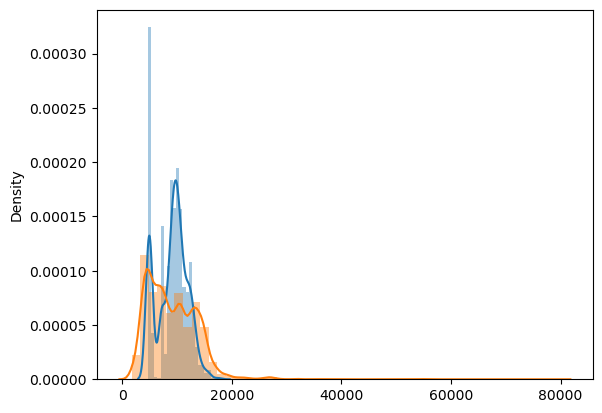

In [120]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

In [121]:
mean_squared_error(y_val, y_pred, squared=False)

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


3697.485935178474

In [122]:
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(f"Root Mean Squared Error on validation set: {rmse}")

Root Mean Squared Error on validation set: 3697.485935178474


In [123]:
with open('../models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [124]:
with mlflow.start_run():

    mlflow.set_tag("developer", "Lamar")

    mlflow.log_param("training-data-path", "../retail_data/flight_dataset.csv")
    mlflow.log_param("validation-data-path", "../retail_data/flight_dataset.csv")
    
    alpha = 0.01
    mlflow.log_param("alpha", alpha)
    mlflow.set_tag("model", "Lasso")
    ls = Lasso(alpha)
    ls.fit(X_train, y_train)
    
    y_pred = ls.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    mlflow.log_metric("rmse", rmse)

    mlflow.log_artifact(local_path="../models/lin_reg.bin", artifact_path="models_pickle")

In [125]:
with open('../models/lin_lasso_reg.bin', 'wb') as f_out:
    pickle.dump((dv, ls), f_out)

In [126]:
import xgboost as xgb

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [127]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [128]:
def objective(params):
    
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=200,
            evals=[(valid, "validation")],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        mlflow.log_metric("rmse", rmse)
        
    return {'loss': rmse, 'status': STATUS_OK}



In [129]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lamdba', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3), 
    'objective': 'reg:linear',
    'seed': 42,
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials())

[0]	validation-rmse:3358.96366                                                                                                                               
[1]	validation-rmse:3360.21295                                                                                                                               
[2]	validation-rmse:3360.97911                                                                                                                               
[3]	validation-rmse:3363.96240                                                                                                                               
[4]	validation-rmse:3360.88587                                                                                                                               
[5]	validation-rmse:3360.91230                                                                                                                               
[6]	validation-rmse:3361.90624                      

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [15:07:02] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[47]	validation-rmse:3358.42000                                                                                                                              
[48]	validation-rmse:3358.49962                                                                                                                              
[49]	validation-rmse:3358.41577                                                                                                                              
[50]	validation-rmse:3358.35072                                                                                                                              
[51]	validation-rmse:3358.42267                                                                                                                              
[52]	validation-rmse:3358.41650                                                                                                                              
[53]	validation-rmse:3358.36262                     

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [15:07:02] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[57]	validation-rmse:3361.33355
[58]	validation-rmse:3361.34476                                                                                                                              
[59]	validation-rmse:3360.55361                                                                                                                              
[60]	validation-rmse:3361.07158                                                                                                                              
[61]	validation-rmse:3361.48878                                                                                                                              
[62]	validation-rmse:3360.82559                                                                                                                              
[63]	validation-rmse:3361.28432                                                                                                                              
[64]	validation-rmse

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [15:07:02] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[51]	validation-rmse:3358.65982                                                                                                                              
[52]	validation-rmse:3358.64030                                                                                                                              
[53]	validation-rmse:3358.63649                                                                                                                              
[54]	validation-rmse:3358.64631                                                                                                                              
[55]	validation-rmse:3358.66735                                                                                                                              
[56]	validation-rmse:3358.69598                                                                                                                              
[57]	validation-rmse:3358.73165                     

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [15:07:03] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[53]	validation-rmse:3357.38456                                                                                                                              
[54]	validation-rmse:3356.88957                                                                                                                              
[55]	validation-rmse:3357.00673                                                                                                                              
[56]	validation-rmse:3357.18645                                                                                                                              
[57]	validation-rmse:3356.78930                                                                                                                              
[58]	validation-rmse:3356.95068                                                                                                                              
[59]	validation-rmse:3356.91670                     

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [15:07:03] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[59]	validation-rmse:3357.51370                                                                                                                              
[60]	validation-rmse:3357.56853                                                                                                                              
[0]	validation-rmse:4377.26043                                                                                                                               
[1]	validation-rmse:4189.93497                                                                                                                               
[2]	validation-rmse:4033.68397                                                                                                                               
[3]	validation-rmse:3904.61247                                                                                                                               
[4]	validation-rmse:3798.42321                      

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [15:07:03] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[55]	validation-rmse:3358.56990                                                                                                                              
[56]	validation-rmse:3357.98719                                                                                                                              
[57]	validation-rmse:3357.47494                                                                                                                              
[58]	validation-rmse:3357.94038                                                                                                                              
[59]	validation-rmse:3358.36471                                                                                                                              
[60]	validation-rmse:3358.20717                                                                                                                              
[61]	validation-rmse:3357.69400                     

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [15:07:03] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:4465.88148                                                                                                                               
[1]	validation-rmse:4343.93573                                                                                                                               
[2]	validation-rmse:4233.98111                                                                                                                               
[3]	validation-rmse:4135.08735                                                                                                                               
[4]	validation-rmse:4046.19036                                                                                                                               
[5]	validation-rmse:3966.62681                                                                                                                               
[6]	validation-rmse:3895.39936                      

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [15:07:04] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[50]	validation-rmse:3355.04062                                                                                                                              
[51]	validation-rmse:3354.96175                                                                                                                              
[52]	validation-rmse:3354.86108                                                                                                                              
[53]	validation-rmse:3354.86341                                                                                                                              
[54]	validation-rmse:3354.65349                                                                                                                              
[55]	validation-rmse:3354.59574                                                                                                                              
[56]	validation-rmse:3354.56743                     

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [15:07:04] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:3852.31371                                                                                                                               
[1]	validation-rmse:3536.92129                                                                                                                               
[2]	validation-rmse:3415.71509                                                                                                                               
[3]	validation-rmse:3372.19919                                                                                                                               
[4]	validation-rmse:3357.96696                                                                                                                               
[5]	validation-rmse:3353.71705                                                                                                                               
[6]	validation-rmse:3353.24412                      

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [15:07:04] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:4227.89146                                                                                                                               
[1]	validation-rmse:3957.61740                                                                                                                               
[2]	validation-rmse:3765.49767                                                                                                                               
[3]	validation-rmse:3631.26768                                                                                                                               
[4]	validation-rmse:3539.74398                                                                                                                               
[5]	validation-rmse:3477.61569                                                                                                                               
[6]	validation-rmse:3435.69612                      

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [15:07:05] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[52]	validation-rmse:3355.79260                                                                                                                              
[53]	validation-rmse:3355.82654                                                                                                                              
[54]	validation-rmse:3355.89543                                                                                                                              
[55]	validation-rmse:3355.95023                                                                                                                              
[56]	validation-rmse:3356.20998                                                                                                                              
[57]	validation-rmse:3356.02532                                                                                                                              
[58]	validation-rmse:3356.03306                     

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [15:07:05] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[63]	validation-rmse:3361.92236                                                                                                                              
[64]	validation-rmse:3361.28407                                                                                                                              
[65]	validation-rmse:3361.33258                                                                                                                              
[66]	validation-rmse:3361.72111                                                                                                                              
[67]	validation-rmse:3361.27933                                                                                                                              
[68]	validation-rmse:3361.19360                                                                                                                              
[69]	validation-rmse:3361.27845                     

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [15:07:05] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[49]	validation-rmse:3363.54569
[50]	validation-rmse:3363.36179                                                                                                                              
[51]	validation-rmse:3363.62010                                                                                                                              
[0]	validation-rmse:3856.62010                                                                                                                               
[1]	validation-rmse:3544.48773                                                                                                                               
[2]	validation-rmse:3423.85106                                                                                                                               
[3]	validation-rmse:3380.48697                                                                                                                               
[4]	validation-rmse:

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [15:07:05] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:4407.37211                                                                                                                               
[1]	validation-rmse:4241.01866                                                                                                                               
[2]	validation-rmse:4098.67589                                                                                                                               
[3]	validation-rmse:3977.29343                                                                                                                               
[4]	validation-rmse:3874.36313                                                                                                                               
[5]	validation-rmse:3787.37011                                                                                                                               
[6]	validation-rmse:3714.18244                      

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [15:07:06] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[43]	validation-rmse:3359.91907                                                                                                                              
[44]	validation-rmse:3360.14903                                                                                                                              
[45]	validation-rmse:3360.53469                                                                                                                              
[46]	validation-rmse:3360.54550                                                                                                                              
[47]	validation-rmse:3360.60725                                                                                                                              
[48]	validation-rmse:3360.98252                                                                                                                              
[49]	validation-rmse:3361.41517                     

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [15:07:06] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [15:07:06] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:4102.07391
[1]	validation-rmse:3789.52661                                                                                                                               
[2]	validation-rmse:3601.77424                                                                                                                               
[3]	validation-rmse:3490.01278                                                                                                                               
[4]	validation-rmse:3424.01096                                                                                                                               
[5]	validation-rmse:3388.99120                                                                                                                               
[6]	validation-rmse:3368.72340                                                                                                                               
[7]	validation-rmse:3

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [15:07:06] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[41]	validation-rmse:3358.75113                                                                                                                              
[42]	validation-rmse:3358.81591                                                                                                                              
[43]	validation-rmse:3358.88811                                                                                                                              
[44]	validation-rmse:3358.96117                                                                                                                              
[45]	validation-rmse:3359.04263                                                                                                                              
[46]	validation-rmse:3359.11705                                                                                                                              
[47]	validation-rmse:3359.19177                     

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [15:07:07] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[34]	validation-rmse:3375.02464                                                                                                                              
[35]	validation-rmse:3372.81898                                                                                                                              
[36]	validation-rmse:3370.99044                                                                                                                              
[37]	validation-rmse:3369.38246                                                                                                                              
[38]	validation-rmse:3368.03492                                                                                                                              
[39]	validation-rmse:3366.80965                                                                                                                              
[40]	validation-rmse:3365.76755                     

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [15:07:08] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[39]	validation-rmse:3358.24141                                                                                                                              
[40]	validation-rmse:3358.82344                                                                                                                              
[41]	validation-rmse:3359.59684                                                                                                                              
[42]	validation-rmse:3358.97302                                                                                                                              
[43]	validation-rmse:3359.18516                                                                                                                              
[44]	validation-rmse:3360.88253                                                                                                                              
[45]	validation-rmse:3359.60463                     

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [15:07:08] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[44]	validation-rmse:3360.99819                                                                                                                              
[45]	validation-rmse:3361.11025                                                                                                                              
[46]	validation-rmse:3361.08616                                                                                                                              
[47]	validation-rmse:3361.19522                                                                                                                              
[48]	validation-rmse:3361.18951                                                                                                                              
[49]	validation-rmse:3361.28031                                                                                                                              
[50]	validation-rmse:3361.26512                     

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [15:07:08] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[20]	validation-rmse:3337.01160
[21]	validation-rmse:3338.31555                                                                                                                              
[22]	validation-rmse:3337.79785                                                                                                                              
[23]	validation-rmse:3337.68425                                                                                                                              
[24]	validation-rmse:3337.61669                                                                                                                              
[25]	validation-rmse:3338.85587                                                                                                                              
[26]	validation-rmse:3339.79216                                                                                                                              
[27]	validation-rmse

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [15:07:09] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:4076.47642                                                                                                                               
[1]	validation-rmse:3760.61201                                                                                                                               
[2]	validation-rmse:3575.63156                                                                                                                               
[3]	validation-rmse:3470.34946                                                                                                                               
[4]	validation-rmse:3414.07320                                                                                                                               
[5]	validation-rmse:3382.36315                                                                                                                               
[6]	validation-rmse:3363.20739                      

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [15:07:09] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[58]	validation-rmse:3349.05730                                                                                                                              
[59]	validation-rmse:3349.00289                                                                                                                              
[60]	validation-rmse:3348.98519                                                                                                                              
[61]	validation-rmse:3349.44965                                                                                                                              
[62]	validation-rmse:3349.48451                                                                                                                              
[63]	validation-rmse:3349.50017                                                                                                                              
[64]	validation-rmse:3349.94117                     

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [15:07:09] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[34]	validation-rmse:3360.32268                                                                                                                              
[35]	validation-rmse:3360.32288                                                                                                                              
[36]	validation-rmse:3360.32304                                                                                                                              
[37]	validation-rmse:3360.32316                                                                                                                              
[38]	validation-rmse:3360.32322                                                                                                                              
[39]	validation-rmse:3360.32330                                                                                                                              
[40]	validation-rmse:3360.32331                     

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [15:07:10] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[60]	validation-rmse:3352.22633
[61]	validation-rmse:3352.49996                                                                                                                              
[62]	validation-rmse:3352.75269                                                                                                                              
[63]	validation-rmse:3353.13633                                                                                                                              
[64]	validation-rmse:3353.19592                                                                                                                              
[65]	validation-rmse:3353.14115                                                                                                                              
[0]	validation-rmse:3441.39585                                                                                                                               
[1]	validation-rmse:

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [15:07:10] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[24]	validation-rmse:3362.32878                                                                                                                              
[25]	validation-rmse:3362.33438                                                                                                                              
[26]	validation-rmse:3362.34667                                                                                                                              
[27]	validation-rmse:3362.38057                                                                                                                              
[28]	validation-rmse:3362.38002                                                                                                                              
[29]	validation-rmse:3362.38446                                                                                                                              
[30]	validation-rmse:3362.40367                     

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [15:07:10] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[28]	validation-rmse:3358.63754                                                                                                                              
[29]	validation-rmse:3358.67884                                                                                                                              
[30]	validation-rmse:3358.74685                                                                                                                              
[31]	validation-rmse:3358.83239                                                                                                                              
[32]	validation-rmse:3358.92803                                                                                                                              
[33]	validation-rmse:3359.02840                                                                                                                              
[34]	validation-rmse:3359.12966                     

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [15:07:11] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[41]	validation-rmse:3360.32345                                                                                                                              
[42]	validation-rmse:3360.32345                                                                                                                              
[43]	validation-rmse:3360.32345                                                                                                                              
[44]	validation-rmse:3360.32345                                                                                                                              
[45]	validation-rmse:3360.32345                                                                                                                              
[46]	validation-rmse:3360.32345                                                                                                                              
[47]	validation-rmse:3360.32345                     

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [15:07:11] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [15:07:11] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[3]	validation-rmse:3611.28454                                                                                                                               
[4]	validation-rmse:3522.44746                                                                                                                               
[5]	validation-rmse:3463.41959                                                                                                                               
[6]	validation-rmse:3424.67148                                                                                                                               
[7]	validation-rmse:3399.52750                                                                                                                               
[8]	validation-rmse:3383.40789                                                                                                                               
[9]	validation-rmse:3373.21759                      

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [15:07:12] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[46]	validation-rmse:3356.79983                                                                                                                              
[47]	validation-rmse:3356.81623                                                                                                                              
[48]	validation-rmse:3356.82360                                                                                                                              
[49]	validation-rmse:3356.83246                                                                                                                              
[50]	validation-rmse:3356.83936                                                                                                                              
[51]	validation-rmse:3356.84559                                                                                                                              
[52]	validation-rmse:3356.85043                     

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [15:07:12] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:3714.59390                                                                                                                               
[1]	validation-rmse:3445.78924                                                                                                                               
[2]	validation-rmse:3376.61127                                                                                                                               
[3]	validation-rmse:3359.29568                                                                                                                               
[4]	validation-rmse:3354.99282                                                                                                                               
[5]	validation-rmse:3353.97108                                                                                                                               
[6]	validation-rmse:3357.03374                      

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [15:07:12] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:4355.31598                                                                                                                               
[1]	validation-rmse:4153.60155                                                                                                                               
[2]	validation-rmse:3989.10907                                                                                                                               
[3]	validation-rmse:3855.96863                                                                                                                               
[4]	validation-rmse:3748.95275                                                                                                                               
[5]	validation-rmse:3663.48339                                                                                                                               
[6]	validation-rmse:3595.61688                      

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [15:07:13] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[37]	validation-rmse:3359.45361                                                                                                                              
[38]	validation-rmse:3359.53745                                                                                                                              
[39]	validation-rmse:3359.61488                                                                                                                              
[40]	validation-rmse:3359.68656                                                                                                                              
[41]	validation-rmse:3359.75173                                                                                                                              
[42]	validation-rmse:3359.81106                                                                                                                              
[43]	validation-rmse:3359.86489                     

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [15:07:13] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[55]	validation-rmse:3360.31947                                                                                                                              
[56]	validation-rmse:3360.32008                                                                                                                              
[57]	validation-rmse:3360.32068                                                                                                                              
[58]	validation-rmse:3360.32113                                                                                                                              
[59]	validation-rmse:3360.32155                                                                                                                              
[60]	validation-rmse:3360.32180                                                                                                                              
[61]	validation-rmse:3360.32213                     

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [15:07:13] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[29]	validation-rmse:3359.04332                                                                                                                              
[30]	validation-rmse:3359.15770                                                                                                                              
[31]	validation-rmse:3359.26963                                                                                                                              
[32]	validation-rmse:3359.37568                                                                                                                              
[33]	validation-rmse:3359.47492                                                                                                                              
[34]	validation-rmse:3359.56665                                                                                                                              
[35]	validation-rmse:3359.65056                     

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [15:07:14] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[77]	validation-rmse:3335.20289                                                                                                                              
[78]	validation-rmse:3335.13639                                                                                                                              
[79]	validation-rmse:3334.54011                                                                                                                              
[80]	validation-rmse:3334.58547                                                                                                                              
[81]	validation-rmse:3334.57079                                                                                                                              
[82]	validation-rmse:3334.62177                                                                                                                              
[83]	validation-rmse:3334.64268                     

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [15:07:14] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[38]	validation-rmse:3353.95282                                                                                                                              
[39]	validation-rmse:3353.52145                                                                                                                              
[40]	validation-rmse:3353.11674                                                                                                                              
[41]	validation-rmse:3352.82325                                                                                                                              
[42]	validation-rmse:3352.89200                                                                                                                              
[43]	validation-rmse:3352.99633                                                                                                                              
[44]	validation-rmse:3353.13143                     

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [15:07:15] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[61]	validation-rmse:3356.96810
[62]	validation-rmse:3357.24847                                                                                                                              
[63]	validation-rmse:3357.56624                                                                                                                              
[64]	validation-rmse:3357.85542                                                                                                                              
[65]	validation-rmse:3358.14798                                                                                                                              
[66]	validation-rmse:3357.90106                                                                                                                              
[67]	validation-rmse:3358.11551                                                                                                                              
[68]	validation-rmse

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [15:07:15] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[28]	validation-rmse:3365.07472                                                                                                                              
[29]	validation-rmse:3363.60109                                                                                                                              
[30]	validation-rmse:3362.26279                                                                                                                              
[31]	validation-rmse:3361.30089                                                                                                                              
[32]	validation-rmse:3360.40570                                                                                                                              
[33]	validation-rmse:3359.80865                                                                                                                              
[34]	validation-rmse:3359.23971                     

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [15:07:16] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[49]	validation-rmse:3360.38808                                                                                                                              
[50]	validation-rmse:3360.35224                                                                                                                              
[51]	validation-rmse:3360.43294                                                                                                                              
[52]	validation-rmse:3360.41855                                                                                                                              
[53]	validation-rmse:3360.52391                                                                                                                              
[54]	validation-rmse:3360.58730                                                                                                                              
[55]	validation-rmse:3360.54888                     

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [15:07:16] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[51]	validation-rmse:3354.48532                                                                                                                              
[52]	validation-rmse:3354.23624                                                                                                                              
[53]	validation-rmse:3354.27841                                                                                                                              
[54]	validation-rmse:3354.57475                                                                                                                              
[55]	validation-rmse:3354.41037                                                                                                                              
[56]	validation-rmse:3354.67292                                                                                                                              
[57]	validation-rmse:3354.72309                     

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [15:07:16] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[42]	validation-rmse:3360.32327                                                                                                                              
[43]	validation-rmse:3360.32327                                                                                                                              
[44]	validation-rmse:3360.32327                                                                                                                              
[45]	validation-rmse:3360.32327                                                                                                                              
[46]	validation-rmse:3360.32327                                                                                                                              
[47]	validation-rmse:3360.32328                                                                                                                              
[48]	validation-rmse:3360.32328                     

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [15:07:17] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[25]	validation-rmse:3432.38073                                                                                                                              
[26]	validation-rmse:3423.93092                                                                                                                              
[27]	validation-rmse:3416.24252                                                                                                                              
[28]	validation-rmse:3409.37623                                                                                                                              
[29]	validation-rmse:3403.38107                                                                                                                              
[30]	validation-rmse:3397.90754                                                                                                                              
[31]	validation-rmse:3393.16160                     

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [15:07:18] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[44]	validation-rmse:3360.46184                                                                                                                              
[45]	validation-rmse:3360.56172                                                                                                                              
[46]	validation-rmse:3360.70338                                                                                                                              
[47]	validation-rmse:3360.65747                                                                                                                              
[48]	validation-rmse:3360.78693                                                                                                                              
[49]	validation-rmse:3360.80668                                                                                                                              
[50]	validation-rmse:3360.87692                     

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [15:07:18] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:4132.59783                                                                                                                               
[1]	validation-rmse:3829.13381                                                                                                                               
[2]	validation-rmse:3638.80963                                                                                                                               
[3]	validation-rmse:3523.01605                                                                                                                               
[4]	validation-rmse:3453.81639                                                                                                                               
[5]	validation-rmse:3412.90186                                                                                                                               
[6]	validation-rmse:3387.32597                      

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [15:07:18] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[44]	validation-rmse:3357.95001                                                                                                                              
[45]	validation-rmse:3357.48140                                                                                                                              
[46]	validation-rmse:3357.36816                                                                                                                              
[47]	validation-rmse:3357.34045                                                                                                                              
[48]	validation-rmse:3357.03916                                                                                                                              
[49]	validation-rmse:3357.64139                                                                                                                              
[50]	validation-rmse:3357.30284                     

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [15:07:18] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[33]	validation-rmse:3363.35185                                                                                                                              
[34]	validation-rmse:3363.52964                                                                                                                              
[35]	validation-rmse:3363.95395                                                                                                                              
[36]	validation-rmse:3363.21206                                                                                                                              
[37]	validation-rmse:3363.58122                                                                                                                              
[38]	validation-rmse:3364.33702                                                                                                                              
[39]	validation-rmse:3364.02646                     

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [15:07:19] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[43]	validation-rmse:3358.64550                                                                                                                              
[44]	validation-rmse:3358.67528                                                                                                                              
[45]	validation-rmse:3358.71705                                                                                                                              
[46]	validation-rmse:3358.76808                                                                                                                              
[47]	validation-rmse:3358.82585                                                                                                                              
[48]	validation-rmse:3358.88825                                                                                                                              
[49]	validation-rmse:3358.95361                     

In [130]:
params = {
'learning_rate': 0.05059823075449685,
'max_depth': 4,
'min_child_weight':5.008520794187583,
'objective':'reg:linear',
'reg_alpha':0.07415085063191965,
'reg_lambda':0.11333795232359768,
'seed':42
}
mlflow.xgboost.autolog(disable=True)

booster = xgb.train(
        params=params,
        dtrain=train,
        num_boost_round=200,
        evals=[(valid, "validation")],
        early_stopping_rounds=50
        )

[0]	validation-rmse:4494.41195
[1]	validation-rmse:4396.23220
[2]	validation-rmse:4305.84720
[3]	validation-rmse:4222.61594
[4]	validation-rmse:4146.18900
[5]	validation-rmse:4076.09819
[6]	validation-rmse:4011.93263
[7]	validation-rmse:3953.14508
[8]	validation-rmse:3899.24441
[9]	validation-rmse:3850.15363
[10]	validation-rmse:3805.21178
[11]	validation-rmse:3764.20674
[12]	validation-rmse:3726.96975
[13]	validation-rmse:3692.79540
[14]	validation-rmse:3661.88846
[15]	validation-rmse:3633.85200
[16]	validation-rmse:3608.30752
[17]	validation-rmse:3584.84806
[18]	validation-rmse:3563.32215
[19]	validation-rmse:3543.69828
[20]	validation-rmse:3526.11281
[21]	validation-rmse:3509.65330
[22]	validation-rmse:3495.42546
[23]	validation-rmse:3482.67046
[24]	validation-rmse:3470.17495
[25]	validation-rmse:3459.62301
[26]	validation-rmse:3449.32536
[27]	validation-rmse:3440.65329
[28]	validation-rmse:3431.98008
[29]	validation-rmse:3424.10006
[30]	validation-rmse:3417.01574
[31]	validation-rm

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [15:07:19] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[129]	validation-rmse:3340.72785
[130]	validation-rmse:3340.95124
[131]	validation-rmse:3340.89376
[132]	validation-rmse:3340.96277
[133]	validation-rmse:3340.95322
[134]	validation-rmse:3340.56721
[135]	validation-rmse:3340.56124
[136]	validation-rmse:3340.70471
[137]	validation-rmse:3340.65382
[138]	validation-rmse:3340.72623
[139]	validation-rmse:3340.77664
[140]	validation-rmse:3340.92909
[141]	validation-rmse:3340.99647
[142]	validation-rmse:3340.95019
[143]	validation-rmse:3341.02070
[144]	validation-rmse:3340.91876
[145]	validation-rmse:3340.96960
[146]	validation-rmse:3340.73327
[147]	validation-rmse:3340.75979
[148]	validation-rmse:3340.80741
[149]	validation-rmse:3340.89243
[150]	validation-rmse:3340.95411
[151]	validation-rmse:3340.77603
[152]	validation-rmse:3340.65926


In [131]:
with mlflow.start_run():
    best_params = {
    'learning_rate': 0.05059823075449685,
    'max_depth': 4,
    'min_child_weight':5.008520794187583,
    'objective':'reg:linear',
    'reg_alpha':0.07415085063191965,
    'reg_lambda':0.11333795232359768,
    'seed':42
    }

    mlflow.log_params(best_params)

    mlflow.set_tag("model", "xgboost_best_param")

    booster = xgb.train(
        params=best_params,
        dtrain=train,
        num_boost_round=400,
        evals=[(valid, "validation")],
        early_stopping_rounds=50
        )

    y_pred = booster.predict(valid)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    mlflow.log_metric("rmse", rmse)

    # with open("../models", "wb") as f_out:
    #     pickle.dump(dv, f_out)

    mlflow.log_artifact(local_path="../models/preprocessor.b", artifact_path="preprocessor")

    mlflow.xgboost.log_model(booster, artifact_path="models_mlflow")

[0]	validation-rmse:4494.41195
[1]	validation-rmse:4396.23220
[2]	validation-rmse:4305.84720
[3]	validation-rmse:4222.61594
[4]	validation-rmse:4146.18900
[5]	validation-rmse:4076.09819
[6]	validation-rmse:4011.93263
[7]	validation-rmse:3953.14508
[8]	validation-rmse:3899.24441
[9]	validation-rmse:3850.15363
[10]	validation-rmse:3805.21178
[11]	validation-rmse:3764.20674
[12]	validation-rmse:3726.96975
[13]	validation-rmse:3692.79540
[14]	validation-rmse:3661.88846
[15]	validation-rmse:3633.85200
[16]	validation-rmse:3608.30752
[17]	validation-rmse:3584.84806
[18]	validation-rmse:3563.32215
[19]	validation-rmse:3543.69828
[20]	validation-rmse:3526.11281
[21]	validation-rmse:3509.65330
[22]	validation-rmse:3495.42546
[23]	validation-rmse:3482.67046
[24]	validation-rmse:3470.17495
[25]	validation-rmse:3459.62301
[26]	validation-rmse:3449.32536
[27]	validation-rmse:3440.65329
[28]	validation-rmse:3431.98008
[29]	validation-rmse:3424.10006
[30]	validation-rmse:3417.01574
[31]	validation-rm

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [15:07:20] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


In [132]:

logged_model = 'runs:/7bfa58a5f28045459f5f2d9f1ac3d1e5/model'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)



/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [15:07:23] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


In [133]:
loaded_model

mlflow.pyfunc.loaded_model:
  artifact_path: model
  flavor: mlflow.xgboost
  run_id: 7bfa58a5f28045459f5f2d9f1ac3d1e5

In [134]:
xgboost_model = mlflow.xgboost.load_model(logged_model)

In [135]:
xgboost_model

In [136]:
y_pred = xgboost_model.predict(valid)

In [137]:
y_pred[:10]

array([11445.923, 10363.26 ,  8623.1  ,  4712.278,  8197.278, 11185.833,
       10363.26 ,  6098.158,  4712.278, 11185.833], dtype=float32)

In [140]:
from mlflow.tracking import MlflowClient

MLFLOW_TRACKING_URI = "sqlite:///mlflow.db"

client = MlflowClient(tracking_uri=MLFLOW_TRACKING_URI)

In [147]:
client.search_registered_models()

[<RegisteredModel: aliases={}, creation_timestamp=1720296667290, description='', last_updated_timestamp=1720297258996, latest_versions=[<ModelVersion: aliases=[], creation_timestamp=1720296692801, current_stage='None', description='', last_updated_timestamp=1720296692801, name='India-flight-price-calculator', run_id='5f61802974b64ec1bd143de8fc88ee8e', run_link='', source='/Users/l.g./Documents/Repo/ml_ops_retail_model_pipeline/model_tracking/mlruns/1/5f61802974b64ec1bd143de8fc88ee8e/artifacts/models_mlflow', status='READY', status_message=None, tags={}, user_id=None, version=2>,
  <ModelVersion: aliases=[], creation_timestamp=1720296729282, current_stage='Staging', description='', last_updated_timestamp=1720297232996, name='India-flight-price-calculator', run_id='9c2f05e8a3be4463b3c3483709f30782', run_link='', source='/Users/l.g./Documents/Repo/ml_ops_retail_model_pipeline/model_tracking/mlruns/1/9c2f05e8a3be4463b3c3483709f30782/artifacts/models_mlflow', status='READY', status_message=

In [148]:
from mlflow.entities import ViewType

runs = client.search_runs(
    experiment_ids='1',
    filter_string="",
    run_view_type=ViewType.ACTIVE_ONLY,
    max_results=5,
    order_by=["metrics.rmse ASC"]
    )

In [151]:
for run in runs:
    print(f"run id: {run.info.run_id}, rmse: {run.data.metrics['rmse']:.4f}")

run id: 45a578cedfc04e3f80412fd777c5406d, rmse: 3340.9519
run id: 5f61802974b64ec1bd143de8fc88ee8e, rmse: 3340.9519
run id: 72a01f6bd4d14632917e095a6440154d, rmse: 3340.9519
run id: 9c2f05e8a3be4463b3c3483709f30782, rmse: 3340.9519
run id: 4e2639064c2441dc9339537e61bbee6b, rmse: 3353.1411
